# Project 4: Poisonous Mushrooms

**Solution**

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 examples, where each describes a mushroom by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. The feature space has been binarized. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using k-means and density estimation with Gaussian mixture models (GMM). Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please **prepare your own write-up and write your own code**.

## Grading
---
- Make sure to answer every part in every question.
 - There are 6 equally weighted questions.
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean and well commented, 
   - and if the functions or answers are too long.

 ## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).

In [1]:
%matplotlib inline

import urllib.request as urllib2 # For python3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

In [2]:
MUSHROOM_DATA = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.data'
MUSHROOM_MAP = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.map'

Load feature names.

In [3]:
feature_names = []

for line in urllib2.urlopen(MUSHROOM_MAP):
    [index, name, junk] = line.decode('utf-8').split()
    feature_names.append(name)

print('Loaded feature names: ', len(feature_names))
print(feature_names)

Loaded feature names:  126
['cap-shape=bell', 'cap-shape=conical', 'cap-shape=convex', 'cap-shape=flat', 'cap-shape=knobbed', 'cap-shape=sunken', 'cap-surface=fibrous', 'cap-surface=grooves', 'cap-surface=scaly', 'cap-surface=smooth', 'cap-color=brown', 'cap-color=buff', 'cap-color=cinnamon', 'cap-color=gray', 'cap-color=green', 'cap-color=pink', 'cap-color=purple', 'cap-color=red', 'cap-color=white', 'cap-color=yellow', 'bruises?=bruises', 'bruises?=no', 'odor=almond', 'odor=anise', 'odor=creosote', 'odor=fishy', 'odor=foul', 'odor=musty', 'odor=none', 'odor=pungent', 'odor=spicy', 'gill-attachment=attached', 'gill-attachment=descending', 'gill-attachment=free', 'gill-attachment=notched', 'gill-spacing=close', 'gill-spacing=crowded', 'gill-spacing=distant', 'gill-size=broad', 'gill-size=narrow', 'gill-color=black', 'gill-color=brown', 'gill-color=buff', 'gill-color=chocolate', 'gill-color=gray', 'gill-color=green', 'gill-color=orange', 'gill-color=pink', 'gill-color=purple', 'gill-col

Load data. The dataset is sparse, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [4]:
X, Y = [], []

for line in urllib2.urlopen(MUSHROOM_DATA):
    items = line.decode('utf-8').split()
    Y.append(int(items.pop(0)))
    x = np.zeros(len(feature_names))
    for item in items:
        feature = int(str(item).split(':')[0])
        x[feature] = 1
    X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


### Question 1:PCA and fraction of total variance
---

1. Do a principal components analysis on the data.
1. Print what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].
1. Show a lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
1. You only need to call PCA.fit once.

Notes:
* The pandas DataFrame [cumsum](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.cumsum.html) function may be helpful.
* You can use `PCA` to produce a PCA analysis.

Fraction of the total variance in the training data explained by the first:
1 principal components: 0.164
2 principal components: 0.297
3 principal components: 0.399
4 principal components: 0.47
5 principal components: 0.508
10 principal components: 0.652
20 principal components: 0.809
30 principal components: 0.899
40 principal components: 0.951
50 principal components: 0.982


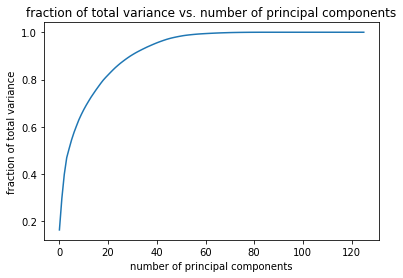

In [5]:
def P1():
    ## STUDENT START ###
    # perform pca on train data
    pca = PCA()
    pca.fit(train_data)
    # get cumulative sum on the list of explained variance ratios for each component
    var_frac = np.cumsum(pca.explained_variance_ratio_)
    print('Fraction of the total variance in the training data explained by the first:')
    for k in [1,2,3,4,5,10,20,30,40,50]:
        print(k ,'principal components:',round(var_frac[k-1],3))
    plt.plot(var_frac)
    plt.title('fraction of total variance vs. number of principal components')
    plt.xlabel('number of principal components')
    plt.ylabel('fraction of total variance')
    plt.show()
    ## STUDENT END ###

P1()

### Question 2: PCA for visualization

PCA can be very useful for visualizing data. 
1. Project the training data down to 2 dimensions and show as a square scatterplot.
  - Show poisonous examples (labeled 1) in red and non-poisonous examples in green (labeled 0)
  - Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

Notes:
* You can use `PCA` to produce a PCA analysis.
* Be sure to add a title, axis labels and a legend to your graph.

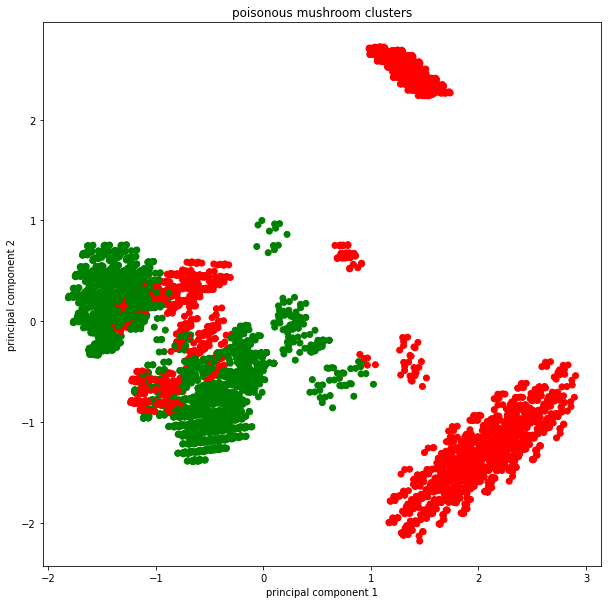

In [6]:
def Q2():   
  ### STUDENT START ###
    # big square plot params
    plt.rcParams["figure.figsize"] = (10,10)
    
    # perform pca on train data and return transformed data
    pca = PCA(2)
    train_pca = pca.fit_transform(train_data)
    # scatter plot with green for non-poisonous red for poisonous
    train_colors = ['green' if i==0 else 'red' for i in train_labels]
    plt.scatter([i[0] for i in train_pca],[i[1] for i in train_pca],c=train_colors)
    plt.title('poisonous mushroom clusters')
    plt.xlabel('principal component 1')
    plt.ylabel('principal component 2')
    plt.show()
  ### STUDENT END ###

Q2()

### Question 3: Visualizing GMMs
---

1. Fit a k-means cluster model with 6 clusters over the 2d projected data. 
  - As in part 2, show as a square scatterplot with the positive (poisonous) examples in red and the negative (non-poisonous) examples in green.  
  - For each cluster, mark the centroid and plot a circle that goes through the cluster's example that is most distant from the centroid.

Notes:
* You can use `KMeans` to produce a k-means cluster analysis.
* You can use `linalg.norm` to determine distance (dissimilarity) between observations.

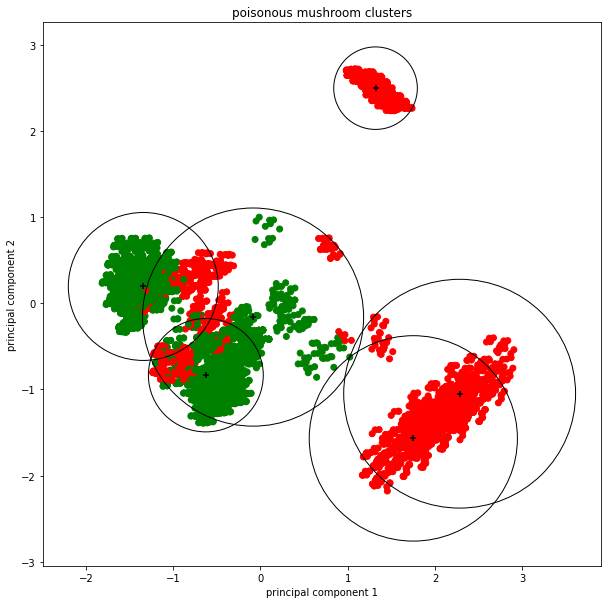

In [7]:
def Q3():   
  ### STUDENT START ###
    #big square plot params
    plt.rcParams["figure.figsize"] = (10,10)
    
    # perform pca on train data and return transformed data
    pca = PCA(2)
    train_pca = pca.fit_transform(train_data)
    kmeans = KMeans(6).fit(train_pca)

    # list comprehensions for colors, cluster coords, and principal components
    train_colors = ['green' if i==0 else 'red' for i in train_labels]
    cx,cy = ([i[0] for i in kmeans.cluster_centers_],[i[1] for i in kmeans.cluster_centers_])
    pca1,pca2 = ([i[0] for i in train_pca],[i[1] for i in train_pca])

    # iterate through cluster centers and labels to find max distance from center to arbitrary cluster point
    radii=[]
    for cluster_center, cluster_label in zip(kmeans.cluster_centers_, range(len(kmeans.cluster_centers_))):
        cluster_points = [point for point, label in zip(train_pca, kmeans.labels_) if label==cluster_label]
        radii.append(max([np.linalg.norm(point - cluster_center) for point in cluster_points]))

    # scatter plot with green for non-poisonous red for poisonous, centroids centers plotted
    plt.scatter(pca1,pca2,c=train_colors)
#     plt.scatter(pca1,pca2,c=kmeans.labels_)
    plt.scatter(cx,cy,marker='+',c='k')

    # plot centroid circles
    circles = [plt.Circle(point, radius = radius, color='k',fill=False) for point,radius in zip (kmeans.cluster_centers_,radii)]
    for circle in circles:
        plt.gca().add_patch(circle)

    # add titles
    plt.title('poisonous mushroom clusters')
    plt.xlabel('principal component 1')
    plt.ylabel('principal component 2')

    # show
    plt.show()

    
  ### STUDENT END ###

Q3()

### Question 4: Understanding GMMs with Density Plots
---

1. Fit Gaussian mixture models for the positive (poisonous) examples in your 2d projected data. 
  - Vary the number of mixture components from 1 to 4 and the covariance matrix type 'spherical', 'diag', 'tied', 'full' (that's 16 models).  
  - Show a 4x4 grid of square-shaped plots of the estimated density contours. 
    - Each row showing a different number of mixture components. 
    - Each column showing a different convariance matrix type.  
1. Be sure to add a title for each plot in the grid to indicate what parameters were used.
1. How are the covariance types 'tied' and 'full' different? How do you see it in the plots?

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* You can use `contour` in combination with other methods to plot contours, like in this example: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py
* You can use `contour` without the `norm` and `levels` parameters. 

<ipython-input-8-48971b00de7b>:36: UserWarning: Log scale: values of z <= 0 have been masked
  plt.subplot(grid_size,grid_size,subplot_index), plt.scatter(pca1,pca2,c='r') ,plt.contour(X,Y,Z,norm=LogNorm(vmin=1.0,vmax=1000.0),levels=np.logspace(0,3,10))
<ipython-input-8-48971b00de7b>:36: UserWarning: Log scale: values of z <= 0 have been masked
  plt.subplot(grid_size,grid_size,subplot_index), plt.scatter(pca1,pca2,c='r') ,plt.contour(X,Y,Z,norm=LogNorm(vmin=1.0,vmax=1000.0),levels=np.logspace(0,3,10))
<ipython-input-8-48971b00de7b>:36: UserWarning: Log scale: values of z <= 0 have been masked
  plt.subplot(grid_size,grid_size,subplot_index), plt.scatter(pca1,pca2,c='r') ,plt.contour(X,Y,Z,norm=LogNorm(vmin=1.0,vmax=1000.0),levels=np.logspace(0,3,10))
<ipython-input-8-48971b00de7b>:36: UserWarning: Log scale: values of z <= 0 have been masked
  plt.subplot(grid_size,grid_size,subplot_index), plt.scatter(pca1,pca2,c='r') ,plt.contour(X,Y,Z,norm=LogNorm(vmin=1.0,vmax=1000.0),levels=np.lo

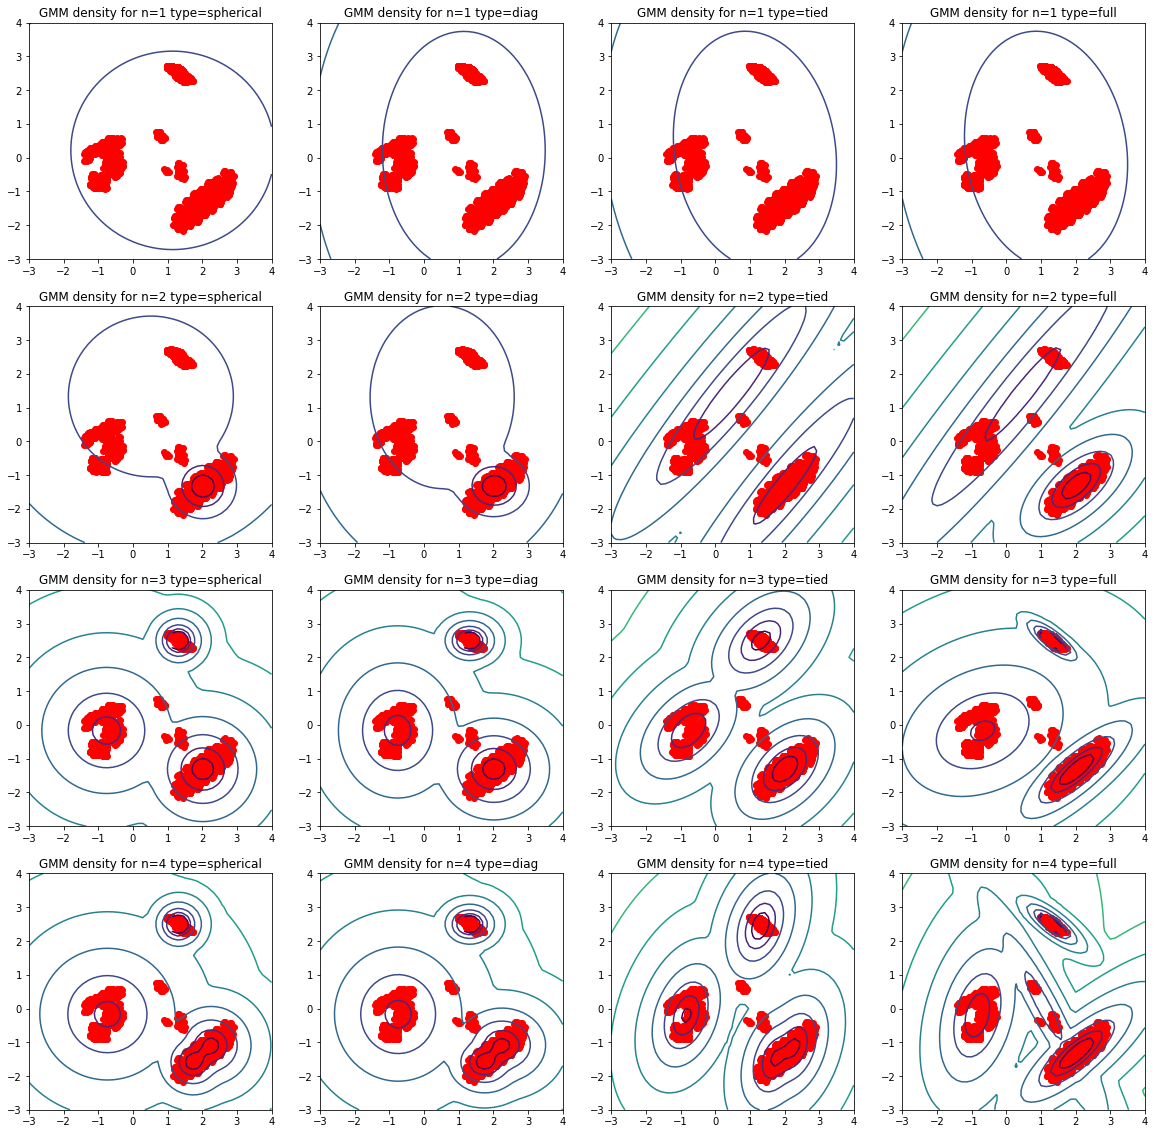

In [8]:
def Q4():
    ### STUDENT START ###
    
    #big square plot params
    plt.rcParams['figure.figsize'] = [20, 20]
    
    # perform pca on train data and return transformed data
    pca = PCA(2)
    train_pca = pca.fit_transform(train_data)
    
    # list comp for only positive examples
    positive_examples = [i for i,j in zip(train_pca,train_labels) if j == 1]
    pca1,pca2 = ([i[0] for i in positive_examples],[i[1] for i in positive_examples])
    n_components = [1,2,3,4]
    covariance_types=['spherical','diag','tied','full']

    # iterate through n_components and covariance_types
    for nc in n_components:
        for ct in covariance_types:
            
            # fit gaussian mixture model
            gm = GaussianMixture(n_components=nc, covariance_type=ct, random_state=12345).fit(positive_examples)

            # display predicted scores by the model as a contour plot
            # forming contour space
            x = np.linspace(-3.0, 4.0)
            y = np.linspace(-3.0, 4.0)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -gm.score_samples(XX)
            Z = Z.reshape(X.shape)

            # form subplot grid
            grid_size = 4
            subplot_index = n_components.index(nc)*4+covariance_types.index(ct)+1
            plt.subplot(grid_size,grid_size,subplot_index), plt.scatter(pca1,pca2,c='r') ,plt.contour(X,Y,Z,norm=LogNorm(vmin=1.0,vmax=1000.0),levels=np.logspace(0,3,10))
            plt.title('GMM density for '+'n='+str(nc)+' type='+str(ct))
    plt.show()
    
    ### STUDENT END ###

Q4()

Answer: In the tied covariance type all components share the same general covariance matrix, while in the full covariance type each component has its own general covariance matrix. This is seen clearly in plot(n=3 type=tied) as the top cluster does not have a density function which matches its orientation, this is due to sharing the general covariance matrix. Comparing to plot(n=3, type=full) we can see the density function is better fit to the top cluster as it has its own general covariance matrix.


### Question 5: Using Unsupervised models for classification...?
---

1. Fit two Gaussian mixture models:
  - On your 2d projected training data. 
    - Form a subset of all the poisonous examples and fit one GMM (gmm_poison).
    - Form a subset of all the non-poisonous examples and fit another GMM (gmm_nonpoison).
  - Use 4 mixture components and full convariance for each model.  
1. Use the above trained GMMs to classify examples in your test set:
   - For each example in the test set
     - Measure how likely it is to have been "generated" by gmm_poison and gmm_nonpoison (using score_samples).
     - Predict the more likely label.
  - You can use score_samples.
  - You can do this without a for loop which will be more efficient.
1. What is the accuracy of the predictions on the test data? (we expect it to be about 0.95)

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* You can use `GaussianMixture`'s `score_samples` method to find the probabilities.

In [9]:
def Q5():  
  ### STUDENT START ###
    
    # perform pca on train data and return transformed data
    pca = PCA(2)
    train_pca = pca.fit_transform(train_data)
    
    #transform (without fit) test data
    test_pca = pca.transform(test_data)

    # list comp for positive/negative examples
    positive_examples = [i for i,j in zip(train_pca,train_labels) if j == 1]
    negative_examples = [i for i,j in zip(train_pca,train_labels) if j == 0]

    # produce gaussian mixture models
    gmm_poison = GaussianMixture(4, covariance_type='full', random_state=12345).fit(positive_examples)
    gmm_nonpoison = GaussianMixture(4, covariance_type='full', random_state=12345).fit(negative_examples)
    
    # pull log-likelihoods
    gmm_poison_prob = gmm_poison.score_samples(test_pca)
    gmm_nonpoison_prob = gmm_nonpoison.score_samples(test_pca)
    
    # compare predicted class with test data
    predicted = np.array([1 if gmm_pp > gmm_npp else 0 for gmm_pp,gmm_npp in zip(gmm_poison_prob,gmm_nonpoison_prob)])
    accuracy = sum(test_labels==predicted)/len(test_labels)
    print('Accuracy:',accuracy)

  ### STUDENT END ###

Q5()

Accuracy: 0.9501779359430605


### Question 6: Understanding the GMM parameters
---

1. Run a series of experiments to find the Gaussian mixture model that results in the best accuracy with no more than 50 parameters.  Do this by varying the number of PCA components, the number of GMM components, and the covariance type.
1. Print the best configuration and accuracy.
1. Plot a scatter plot of accuracy vs #params.
1. Bonus: Provide a better visualization by showing all four: accuracy, number of parameters, the covariance type and the number of PCA dimensions.



Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* [This spreadsheet](https://docs.google.com/spreadsheets/d/1LTEOU7q_Tgs4bX_3o2ePjDQrTRToZoc1J5XLlaRbmI0/edit?usp=sharing) should help (accessible from your google @berkeley.edu account)

* Spherical - Each GMM component has a mean per dimension, and one variance. 
* Diag - Each GMM component has a mean per dimension and a variance for each dimension.
* full - Each GMM component has a mean per dimension and a "full" covariance matrix. Only the covariance matrix is symmetric, so its $[i,j]$ entry would equal to its $[j,i]$ entry.
* tied - Finally, tied has all components share a single covariance matrix. So each GMM component has a mean per dimension but they all share the same 'full' covariance matrix.


Best Configuration:
    n_pca: 6
    n_gmm: 2
    covariance type: diag
    number of params: 50
    accuracy: 0.9733096085409253


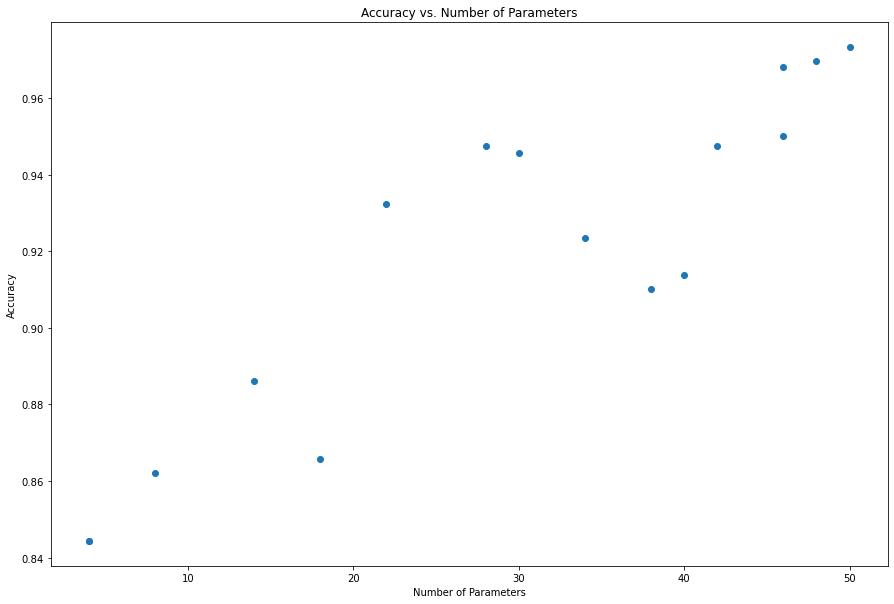


BONUS:


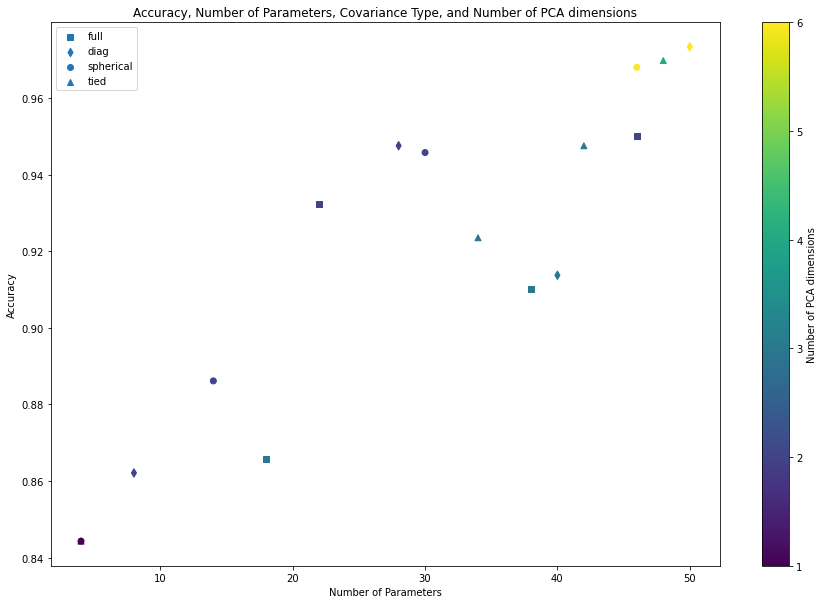

In [10]:
from matplotlib.lines import Line2D

def Q6():
  ### STUDENT START ###

    # big square plot params
    plt.rcParams['figure.figsize'] = [15, 10]

    # list of params I tried
    params =[
        (3,1,'full',18),
        (3,2,'full',38),
        (2,4,'full',46),
        (2,2,'full',22),
        (2,1,'diag',8),
        (3,3,'diag',40),
        (2,3,'diag',28),
        (6,2,'diag',50),
        (6,3,'spherical',46),
        (1,1,'spherical',4),
        (2,2,'spherical',14),
        (2,4,'spherical',30),
        (4,3,'tied',48),
        (3,4,'tied',42),
        (1,1,'tied',4),
        (3,3,'tied',34)]
    
    accuracies = []
    for n_pca,n_gmm,ct,param_num in params: 
        # perform pca on train data and return transformed data
        pca = PCA(n_pca)
        train_pca = pca.fit_transform(train_data)

        #transform (without fit) test data
        test_pca = pca.transform(test_data)

        # list comp for positive/negative examples
        positive_examples = [i for i,j in zip(train_pca,train_labels) if j == 1]
        negative_examples = [i for i,j in zip(train_pca,train_labels) if j == 0]

        # produce gaussian mixture models
        gmm_poison = GaussianMixture(n_gmm, covariance_type=ct, random_state=12345).fit(positive_examples)
        gmm_nonpoison = GaussianMixture(n_gmm, covariance_type=ct, random_state=12345).fit(negative_examples)

        # pull log-likelihoods
        gmm_poison_prob = gmm_poison.score_samples(test_pca)
        gmm_nonpoison_prob = gmm_nonpoison.score_samples(test_pca)

        # compare predicted class with test data
        predicted = np.array([1 if gmm_pp > gmm_npp else 0 for gmm_pp,gmm_npp in zip(gmm_poison_prob,gmm_nonpoison_prob)])
        accuracy = sum(test_labels==predicted)/len(test_labels)
        accuracies.append(accuracy)
    
    # find index of max to pull most accurate config
    max_index = accuracies.index(max(accuracies))
    n_pca_list = [i[0] for i in params]
    n_gmm_list = [i[1] for i in params]
    ct_list = [i[2] for i in params]
    param_num = [i[3] for i in params]

    # print best config
    print()
    print('Best Configuration:')
    print('   ','n_pca:',n_pca_list[max_index])
    print('   ','n_gmm:',n_gmm_list[max_index])
    print('   ','covariance type:',ct_list[max_index])
    print('   ','number of params:',param_num[max_index])
    print('   ','accuracy:',max(accuracies))
    
    # simple scatter
    plt.scatter(param_num,accuracies)
    plt.title('Accuracy vs. Number of Parameters')
    plt.xlabel('Number of Parameters')
    plt.ylabel('Accuracy')
    plt.show()
    
    vmin, vmax = min(n_pca_list), max(n_pca_list)

    # making lists for each scatter plot so I can have different markers depending on the covariance type
    param_num_full = [i for i,j in zip(param_num,ct_list) if j=='full']
    param_num_diag = [i for i,j in zip(param_num,ct_list) if j=='diag']
    param_num_spherical = [i for i,j in zip(param_num,ct_list) if j=='spherical']
    param_num_tied = [i for i,j in zip(param_num,ct_list) if j=='tied']
    
    accuracies_full = [i for i,j in zip(accuracies,ct_list) if j=='full']
    accuracies_diag = [i for i,j in zip(accuracies,ct_list) if j=='diag']
    accuracies_spherical = [i for i,j in zip(accuracies,ct_list) if j=='spherical']
    accuracies_tied = [i for i,j in zip(accuracies,ct_list) if j=='tied']
    
    n_pca_list_full = [i for i,j in zip(n_pca_list,ct_list) if j=='full']
    n_pca_list_diag = [i for i,j in zip(n_pca_list,ct_list) if j=='diag']
    n_pca_list_spherical = [i for i,j in zip(n_pca_list,ct_list) if j=='spherical']
    n_pca_list_tied = [i for i,j in zip(n_pca_list,ct_list) if j=='tied']
    
    print()
    print('BONUS:')
    plt.scatter(param_num_full,accuracies_full,c=n_pca_list_full,vmin=vmin,vmax=vmax,marker='s',label='full')
    plt.scatter(param_num_diag,accuracies_diag,c=n_pca_list_diag,vmin=vmin,vmax=vmax,marker='d',label='diag')
    plt.scatter(param_num_spherical,accuracies_spherical,c=n_pca_list_spherical,vmin=vmin,vmax=vmax,marker='o',label='spherical')
    plt.scatter(param_num_tied,accuracies_tied,c=n_pca_list_tied,vmin=vmin,vmax=vmax,marker='^',label='tied')
    plt.legend()
    plt.colorbar().ax.set_ylabel('Number of PCA dimensions', rotation=90)

    plt.title('Accuracy, Number of Parameters, Covariance Type, and Number of PCA dimensions')
    plt.xlabel('Number of Parameters')
    plt.ylabel('Accuracy')
    plt.show()
    

  ### STUDENT END ###

Q6()